In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from tqdm import tqdm

import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
IMAGE_SIZE = 64
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1
num_epochs = 100
image_size = IMAGE_SIZE  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
num_classes = 7


IMAGE_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# train_df = pd.read_csv('../input/deeplearningchallengeholidays/dataset/train.csv')
# train_df['Kfold']=-1
# train_df=train_df.sample(frac=1).reset_index(drop=True)
# y=train_df['Class']
# kf=StratifiedKFold(n_splits=10)
# for fold,(t_,v_) in enumerate(kf.split(X=train_df,y=y)):
#     train_df.loc[v_,'Kfold']=fold
# train_data_df=train_df[train_df['Kfold']!=4]
# valid_data_df=train_df[train_df['Kfold']==4]

In [5]:
from pathlib import Path
import os 

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((image_size,image_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img
    

train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = train_datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [6]:
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
# classes = [classes[k] for k in classes]
classes

{0: 'AlgodaoBravo',
 1: 'AmorAgarradinho',
 2: 'AveDoParaiso',
 3: 'Calistemo',
 4: 'Jasmim',
 5: 'LantanaRasteira',
 6: 'OrquideaPintada'}

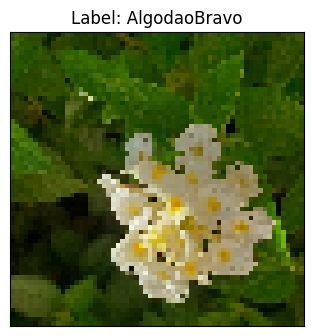

In [7]:
def view_images(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset

    fig = plt.figure(figsize=(22, 22))
    for i in range(1):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {classes[np.argmax(label[i])]}")

view_images(valid_generator)

In [8]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
class_weights


{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}

In [9]:
x_train = []
y_train = []
x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(valid_generator)

for i in range(len(train_generator)-1):
    x_train = np.append(x_train, train_generator[i+1][0], axis=0)
    y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(valid_generator)-1):
    x_test = np.append(x_test, valid_generator[i+1][0], axis=0)
    y_test = np.append(y_test, valid_generator[i+1][1], axis=0)



In [12]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_test = y_test.reshape((36,1))
y_train = y_train.reshape((281,1))
y_test = y_test.astype(int)

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (281, 64, 64, 3) - y_train shape: (281,)
x_test shape: (36, 64, 64, 3) - y_test shape: (36,)


In [18]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [20]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [22]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=d87cf641f8ab8913e9959a4b5b5ff1b3ebb4f8ba81d924e2ffa131cd3ff4c8c4
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [41]:
# from vit_keras import vit, utils

# def create_vit_classifier():
#     inputs = layers.Input(shape=input_shape)
#     # Augment data.
#     augmented = data_augmentation(inputs)


#     pre_trained_model = vit.vit_l32(
#         image_size=IMAGE_SIZE,
#         activation='sigmoid',
#         pretrained=True,
#         include_top=True,
#         pretrained_top=True,
#         classes=num_classes
#     )
#     pre_trained_model.trainable = False
#     features = pre_trained_model(augmented)
#     features = layers.Dense(512, activation=layers.PReLU())(features)
#     features = layers.Dropout(0.2)(features)
#     features = layers.Dense(256, activation=layers.PReLU())(features)
#     features = layers.Dropout(0.2)(features)
#     features = layers.Dense(128, activation=layers.PReLU())(features)
#     features = layers.Dropout(0.2)(features)

#     outputs = layers.Dense(num_classes, activation="softmax")(features)
#     model = keras.Model(inputs=inputs,outputs=outputs)
#     return model

In [25]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [21]:
# def run_experiment(model):
    
    
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.CategoricalCrossentropy(),
#         metrics=[
#             keras.metrics.CategoricalAccuracy(name="accuracy"),
#             keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
#         ],
#     )

#     checkpoint_filepath = "/tmp/checkpoint"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )
#     early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
#     history = model.fit(
#         train_generator,
#         batch_size=batch_size,
#         epochs=num_epochs,
#         class_weight=class_weights,
#         validation_data=valid_generator,
#         callbacks=[checkpoint_callback,early_stopping],
#     )
#     pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
    
#     model.trainable = True
#     history = model.fit(
#         train_generator,
#         batch_size=batch_size,
#         epochs=num_epochs // 2,
#         class_weight=class_weights,
#         validation_data=valid_generator,
#         callbacks=[checkpoint_callback,early_stopping],
#     )
    
#     model.load_weights(checkpoint_filepath)
    
#     _, accuracy, top_2_accuracy = model.evaluate(valid_generator)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")
    
#     pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
#     model.save("./vit_best_model.h5")
#     return history


# vit_classifier = create_vit_classifier()
# history = run_experiment(vit_classifier)

Epoch 1/100
281/281 [==============================] - 24s 38ms/step - loss: 15.2883 - accuracy: 0.3132 - top-5-accuracy: 0.8078 - val_loss: 8.5232 - val_accuracy: 0.2500 - val_top-5-accuracy: 0.8056
Epoch 2/100
281/281 [==============================] - 7s 25ms/step - loss: 7.0121 - accuracy: 0.3274 - top-5-accuracy: 0.8932 - val_loss: 6.3988 - val_accuracy: 0.1944 - val_top-5-accuracy: 0.8333
Epoch 3/100
281/281 [==============================] - 9s 33ms/step - loss: 4.0296 - accuracy: 0.4448 - top-5-accuracy: 0.9039 - val_loss: 2.3053 - val_accuracy: 0.5278 - val_top-5-accuracy: 0.9722
Epoch 4/100
281/281 [==============================] - 7s 25ms/step - loss: 2.2253 - accuracy: 0.5623 - top-5-accuracy: 0.9644 - val_loss: 1.7626 - val_accuracy: 0.5278 - val_top-5-accuracy: 0.9444
Epoch 5/100
281/281 [==============================] - 9s 31ms/step - loss: 1.5605 - accuracy: 0.5979 - top-5-accuracy: 0.9609 - val_loss: 1.6091 - val_accuracy: 0.5833 - val_top-5-accuracy: 1.0000
Epoch 6/

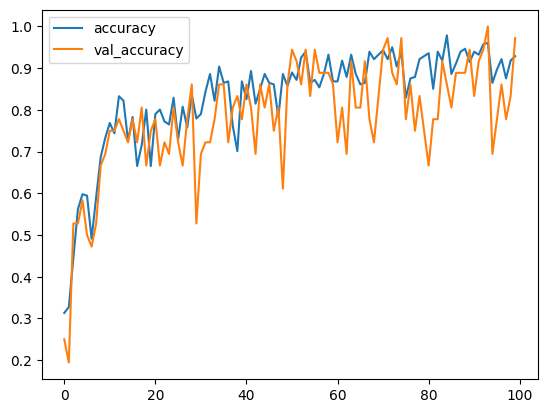

In [27]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test,y_test),
        callbacks=[checkpoint_callback],
    )
    pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
    
    # model.trainable = True
    # history = model.fit(
    #     train_generator,
    #     batch_size=batch_size,
    #     epochs=num_epochs // 2,
    #     class_weight=class_weights,
    #     validation_data=valid_generator,
    #     callbacks=[checkpoint_callback,early_stopping],
    # )
    
    # model.load_weights(checkpoint_filepath)
    
    # _, accuracy, top_2_accuracy = model.evaluate(valid_generator)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")
    
    # pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
    # model.save("./vit_best_model.h5")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

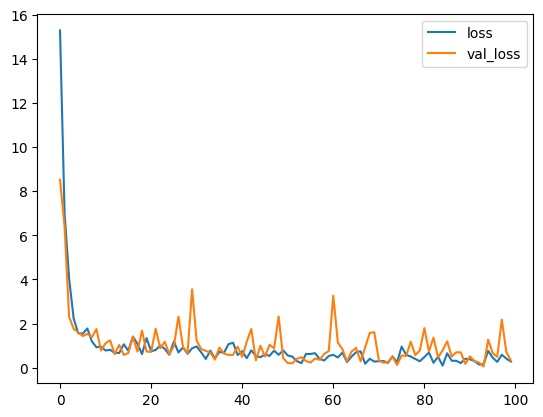

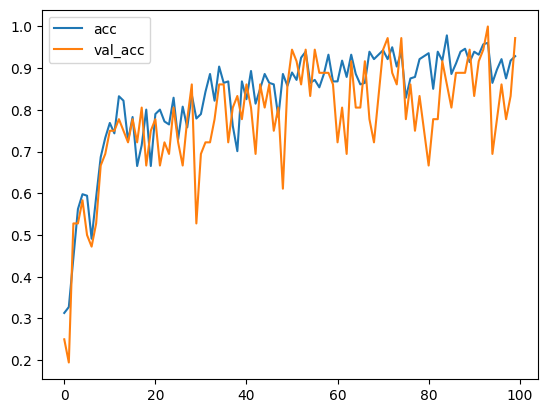

In [28]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [29]:
vit_classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 64, 64, 3)   7           ['input_3[0][0]']                
                                                                                                  
 patches_2 (Patches)            (None, None, 108)    0           ['data_augmentation[2][0]']      
                                                                                                  
 patch_encoder_2 (PatchEncoder)  (None, 100, 64)     13376       ['patches_2[0][0]']              
                                                                                            